## top-R (擬似的実数版top-k)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import itertools
from random import shuffle
import codecs

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

Using TensorFlow backend.


In [3]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)
    else:
        print("sth wrong")

In [4]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = np.array([s_cls[i] for i in l_indexes])
    return labels

In [5]:
# labelling and evaluating them
def topk_scls_eval(part, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]
    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    # generate an annotator
    ann_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    
    # for top-1.0
    if (part == 0):
        mul_labels = ann_model.predict(trn_imgs[orig_A:orig_A + lim_A])
        # labels score evaluation
        score = 0
        for label, t_label in zip(mul_labels, trn_labels[orig_A:orig_A + lim_A]):
            if (label == t_label):
                score += 1
        
        return (1.0, score*100/len(mul_labels), score*100/lim_A)
    
    # for top-R (1.05, 1.1, ..., 1.25)
    else:
        # split data to label into two groups
        f_imgs, s_imgs, f_labels, s_labels = train_test_split(trn_imgs[orig_A:orig_A + lim_A], trn_labels[orig_A:orig_A + lim_A], test_size = part/100)
        # top-1
        f_ann_proba = ann_model.predict_proba(f_imgs)
        ord_labels = [topk_label(probas, s_cls, 1) for probas in f_ann_proba]
        # top-2
        s_ann_proba = ann_model.predict_proba(s_imgs)
        top2_labels = [topk_label(probas, s_cls, 2) for probas in s_ann_proba]
        # concat top-1 results and top-2 results
        mul_labels = ord_labels + top2_labels
        
        # labels score evaluation
        score = 0
        for labels, t_label in zip(mul_labels, f_labels + s_labels):
            for l in labels:
                if (l == t_label):
                    score += 1

        m_labels = []
        for labels in mul_labels:
             [m_labels.append(l) for l in labels]                
                    
        return (len(m_labels)/lim_A, score*100/len(m_labels), score*100/lim_A)

In [6]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])
img_SIZE = train_images.shape[1]*train_images.shape[2]

### Rは1.00-1.25を0.05刻みで

In [7]:
Rs = [i/100 for i in range(100, 130, 5)]
for R in Rs:
    print (f"top-{R}; {round((R - 1.00)*100)}% of data mul-labelled")

top-1.0; 0% of data mul-labelled
top-1.05; 5% of data mul-labelled
top-1.1; 10% of data mul-labelled
top-1.15; 15% of data mul-labelled
top-1.2; 20% of data mul-labelled
top-1.25; 25% of data mul-labelled


### さしあたりtop-1とtop-2の組み合わせで実装(25/02/2020)

In [8]:
# main experiment
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

In [9]:
# main experiment
Rs = [i/100 for i in range(100, 130, 5)]
for R in Rs:
    mnist_evals = []
    part = round((R - 1.00)*100)
    for i in range(2, 11): # i: num of sub-classes
        print(f"{i} classes, top-{R}, {part}% of data mul-labelled")
        combi_ni = fact_10//(factorial(i)*factorial(10 - i))
        a, b, c = 0, 0, 0
        
        if (i == 10):
            a, b, c = 0, 0, 0
            for _ in range(5):
                d, e, f = topk_scls_eval(part, [a for a in range(10)], orig_A1, lim_A1)
                a += d
                b += e
                c += f
            sample_lnum, sample_lqual, sample_lqual2 = a/5, b/5, c/5 
            mnist_evals.append((sample_lnum, sample_lqual, sample_lqual2))
        else:
            continue
#             for scls in itertools.combinations(classes, i):
#                 x, y, z = 0, 0, 0
#                 for _ in range(5):
#                     s, t, u = topk_scls_eval(part, list(scls), orig_A1, lim_A1)
#                     x += s
#                     y += t
#                     z += u
#                 sample_lnum, sample_lqual, sample_lqual2 = x/5, y/5, z/5
#                 a += sample_lnum
#                 b += sample_lqual
#                 c += sample_lqual2
#             mnist_evals.append((a/combi_ni, b/combi_ni, c/combi_ni))
    print(mnist_evals)

2 classes, top-1.0, 0% of data mul-labelled
3 classes, top-1.0, 0% of data mul-labelled
4 classes, top-1.0, 0% of data mul-labelled
5 classes, top-1.0, 0% of data mul-labelled
6 classes, top-1.0, 0% of data mul-labelled
7 classes, top-1.0, 0% of data mul-labelled
8 classes, top-1.0, 0% of data mul-labelled
9 classes, top-1.0, 0% of data mul-labelled
10 classes, top-1.0, 0% of data mul-labelled
[(1.0, 84.8, 84.8)]
2 classes, top-1.05, 5% of data mul-labelled
3 classes, top-1.05, 5% of data mul-labelled
4 classes, top-1.05, 5% of data mul-labelled
5 classes, top-1.05, 5% of data mul-labelled
6 classes, top-1.05, 5% of data mul-labelled
7 classes, top-1.05, 5% of data mul-labelled
8 classes, top-1.05, 5% of data mul-labelled
9 classes, top-1.05, 5% of data mul-labelled
10 classes, top-1.05, 5% of data mul-labelled
[(1.05, 81.13333333333333, 85.19)]
2 classes, top-1.1, 10% of data mul-labelled
3 classes, top-1.1, 10% of data mul-labelled
4 classes, top-1.1, 10% of data mul-labelled
5 class

### グラフ用

In [2]:
R1 = [(1.0, 97.91555555555556, 97.91555555555556), (1.0, 95.70125000000003, 95.70125000000003), (1.0, 93.45761904761905, 93.45761904761905), (1.0, 91.62242063492069, 91.62242063492069), (1.0, 90.20309523809519, 90.20309523809519), (1.0, 88.35958333333333, 88.35958333333333), (1.0, 86.63111111111112, 86.63111111111112), (1.0, 85.8, 85.8), (1.0, 84.8, 84.8)]
R105 = [(1.0499999999999994, 93.34835978835979, 98.01577777777779), (1.049999999999998, 91.30658730158731, 95.87191666666669), (1.0500000000000036, 89.22530612244897, 93.68657142857147), (1.050000000000005, 87.51383219954643, 91.8895238095238), (1.0500000000000036, 86.1877097505669, 90.49709523809518), (1.049999999999998, 84.44865079365081, 88.6710833333333), (1.0499999999999994, 82.84994708994708, 86.99244444444446), (1.0500000000000003, 82.10857142857142, 86.214), (1.05, 81.13333333333333, 85.19)]
R110 = [(1.1000000000000008, 89.20101010101007, 98.1211111111111), (1.0999999999999976, 87.31242424242423, 96.04366666666668), (1.0999999999999963, 85.38346320346325, 93.92180952380946), (1.099999999999998, 83.78903318903325, 92.16793650793647), (1.0999999999999963, 82.53064935064936, 90.78371428571428), (1.0999999999999976, 80.89939393939393, 88.98933333333338), (1.1000000000000008, 79.40929292929293, 87.3502222222222), (1.0999999999999999, 78.67272727272727, 86.53999999999999), (1.1, 77.84545454545454, 85.63000000000001)]
R115 = [(1.149999999999999, 85.41951690821254, 98.23244444444444), (1.1500000000000026, 83.66934782608698, 96.21975000000002), (1.150000000000004, 81.86521739130433, 94.14499999999998), (1.150000000000001, 80.37705314009659, 92.43361111111109), (1.150000000000004, 79.20041407867494, 91.08047619047616), (1.1500000000000026, 77.64594202898549, 89.29283333333335), (1.149999999999999, 76.27497584541062, 87.71622222222219), (1.1500000000000001, 75.57217391304349, 86.90800000000002), (1.15, 74.71304347826087, 85.92)]
R120 = [(1.2000000000000008, 81.95703703703701, 98.34844444444447), (1.2000000000000004, 80.33027777777777, 96.3963333333333), (1.1999999999999953, 78.64257936507943, 94.37109523809531), (1.1999999999999942, 77.2594907407407, 92.71138888888883), (1.1999999999999953, 76.14583333333331, 91.37499999999999), (1.2000000000000004, 74.68027777777779, 89.61633333333333), (1.2000000000000008, 73.39537037037039, 88.07444444444442), (1.1999999999999997, 72.7525, 87.30300000000001), (1.2, 71.96666666666667, 86.36000000000001)]
R125 = [(1.25, 78.75413333333333, 98.44266666666668), (1.25, 77.2498, 96.56225), (1.25, 75.68685714285712, 94.60857142857144), (1.25, 74.3832698412699, 92.97908730158727), (1.25, 73.3336, 91.66699999999996), (1.25, 71.93293333333334, 89.91616666666661), (1.25, 70.75946666666665, 88.44933333333334), (1.25, 70.0904, 87.61300000000001), (1.25, 69.312, 86.64)]

In [3]:
results_list = [R1, R105, R110, R115, R120, R125]

In [12]:
results_list[1][8][1]

79.91428571428571

In [19]:
lqual_10cls = [results_list[i][8][1] for i in range(6)]

In [28]:
lqual_10cls

[83.5,
 79.91428571428571,
 76.63636363636364,
 73.81739130434782,
 70.825,
 68.49600000000001]

In [29]:
Rs

[1.0, 1.05, 1.1, 1.15, 1.2, 1.25]

In [4]:
qzero_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0334791666666665, 93.6843518370719, 96.76875000000001), (1.0668666666666662, 89.47267758364897, 95.36976190476183), (1.09899603174603, 85.8062582442501, 94.20972222222221), (1.1204880952380947, 83.1971582554879, 93.14333333333335), (1.1499875000000002, 79.74666930534073, 91.64916666666667), (1.1786222222222222, 76.93905685280227, 90.64999999999998), (1.2072499999999997, 74.74123905374579, 90.22), (1.224, 73.24346405228758, 89.65)]]
qtenth_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0153624999999995, 94.85813232195665, 96.28750000000001), (1.040192857142857, 91.17737449617876, 94.78523809523807), (1.0631765873015873, 88.0097438324857, 93.50714285714292), (1.078071428571429, 85.68343541307117, 92.31785714285716), (1.0971541666666669, 82.77710753888428, 90.78208333333332), (1.1163999999999996, 80.28869810847034, 89.61444444444443), (1.1384, 78.31796205282639, 89.15), (1.153, 76.71292281006072, 88.45)]]
qhalf_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000829166666667, 95.65711936176007, 95.73416666666675), (1.00932619047619, 92.99069821528626, 93.84071428571428), (1.0211329365079373, 90.51513899763995, 92.4017857142857), (1.0303785714285714, 88.5260226380746, 91.18857142857144), (1.0412875000000008, 86.02027569573764, 89.55208333333334), (1.0522666666666665, 83.88761737437736, 88.26333333333336), (1.0673, 82.19186677383794, 87.72000000000001), (1.0715, 80.86794213719085, 86.65)]]
qshannon_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0002666666666673, 95.68549599721796, 95.71041666666675), (1.0038880952380944
, 93.26399325942879, 93.61928571428577), (1.0108154761904755, 91.04578412095299, 92.0160714285714), (1.0168833333333336, 89.25887661366012, 
90.74976190476191), (1.0251500000000002, 86.91056740481199, 89.08374999999998), (1.0323444444444445, 84.92817190015958, 87.6688888888889), (
1.04225, 83.53148915619434, 87.05499999999999), (1.051, 82.20742150333017, 86.4)]]
q2_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000145833333334, 95.69390536534902, 95.70750000000007), (1.0027000000000004, 93.32589589872764, 93.57238095238102), (1.0079464285714281, 91.19911103693669, 91.91250000000001), (1.0126523809523802, 89.49826752257391, 90.61785714285712), (1.0195166666666664, 87.22926874979792, 88.92166666666664), (1.0256222222222224, 85.28469966288097, 87.46444444444444), (1.03315, 84.06680236236342, 86.85000000000001), (1.0425, 82.54196642685851, 86.05)]]
q10_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0000791666666669, 95.6972572093726, 95.7045833333334), (1.001816666666666, 93.3721980271965, 93.53785714285718), (1.0055555555555549, 91.32998825165733, 91.82837301587303), (1.008983333333333, 89.70908372946477, 90.50523809523814), (1.0142625, 87.53556894037482, 88.775), (1.0189111111111109, 85.65135997826238, 87.26555555555554), (1.02585, 84.45058240098153, 86.63000000000001), (1.0315, 83.08288899660688, 85.7)]]
qtop1_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0, 95.70083333333339, 95.70083333333339), (1.0, 93.45857142857146, 93.45857142857146), (1.0, 91.61924603174603, 91.61924603174603), (1.0, 90.20047619047618, 90.20047619047618), (1.0, 88.34375000000001, 88.34375000000001), (1.0, 86.64555555555555, 86.64555555555555), (1.0, 85.785, 85.785), (1.0, 84.8, 84.8)]]

In [5]:
qlnum = [qzero_lnum, qtenth_lnum, qhalf_lnum, qshannon_lnum, q2_lnum, q10_lnum, qtop1_lnum]

In [6]:
qzero = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0334791666666665, 93.6843518370719, 96.76875000000001), (1.0668666666666662, 89.47267758364897, 95.36976190476183), (1.09899603174603, 85.8062582442501, 94.20972222222221), (1.1204880952380947, 83.1971582554879, 93.14333333333335), (1.1499875000000002, 79.74666930534073, 91.64916666666667), (1.1786222222222222, 76.93905685280227, 90.64999999999998), (1.2072499999999997, 74.74123905374579, 90.22), (1.224, 73.24346405228758, 89.65)]]
qtenth = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0153624999999995, 94.85813232195665, 96.28750000000001), (1.040192857142857, 91.17737449617876, 94.78523809523807), (1.0631765873015873, 88.0097438324857, 93.50714285714292), (1.078071428571429, 85.68343541307117, 92.31785714285716), (1.0971541666666669, 82.77710753888428, 90.78208333333332), (1.1163999999999996, 80.28869810847034, 89.61444444444443), (1.1384, 78.31796205282639, 89.15), (1.153, 76.71292281006072, 88.45)]]
qhalf = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000829166666667, 95.65711936176007, 95.73416666666675), (1.00932619047619, 92.99069821528626, 93.84071428571428), (1.0211329365079373, 90.51513899763995, 92.4017857142857), (1.0303785714285714, 88.5260226380746, 91.18857142857144), (1.0412875000000008, 86.02027569573764, 89.55208333333334), (1.0522666666666665, 83.88761737437736, 88.26333333333336), (1.0673, 82.19186677383794, 87.72000000000001), (1.0715, 80.86794213719085, 86.65)]]
qshannon = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0002666666666673, 95.68549599721796, 95.71041666666675), (1.0038880952380944
, 93.26399325942879, 93.61928571428577), (1.0108154761904755, 91.04578412095299, 92.0160714285714), (1.0168833333333336, 89.25887661366012, 
90.74976190476191), (1.0251500000000002, 86.91056740481199, 89.08374999999998), (1.0323444444444445, 84.92817190015958, 87.6688888888889), (
1.04225, 83.53148915619434, 87.05499999999999), (1.051, 82.20742150333017, 86.4)]]
q2 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000145833333334, 95.69390536534902, 95.70750000000007), (1.0027000000000004, 93.32589589872764, 93.57238095238102), (1.0079464285714281, 91.19911103693669, 91.91250000000001), (1.0126523809523802, 89.49826752257391, 90.61785714285712), (1.0195166666666664, 87.22926874979792, 88.92166666666664), (1.0256222222222224, 85.28469966288097, 87.46444444444444), (1.03315, 84.06680236236342, 86.85000000000001), (1.0425, 82.54196642685851, 86.05)]]
q10 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0000791666666669, 95.6972572093726, 95.7045833333334), (1.001816666666666, 93.3721980271965, 93.53785714285718), (1.0055555555555549, 91.32998825165733, 91.82837301587303), (1.008983333333333, 89.70908372946477, 90.50523809523814), (1.0142625, 87.53556894037482, 88.775), (1.0189111111111109, 85.65135997826238, 87.26555555555554), (1.02585, 84.45058240098153, 86.63000000000001), (1.0315, 83.08288899660688, 85.7)]]
qtop1 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0, 95.70083333333339, 95.70083333333339), (1.0, 93.45857142857146, 93.45857142857146), (1.0, 91.61924603174603, 91.61924603174603), (1.0, 90.20047619047618, 90.20047619047618), (1.0, 88.34375000000001, 88.34375000000001), (1.0, 86.64555555555555, 86.64555555555555), (1.0, 85.785, 85.785), (1.0, 84.8, 84.8)]]

In [7]:
qqual = [qzero, qtenth, qhalf, qshannon, q2, q10, qtop1]

In [8]:
tsallis_10cls = [73.24346405228758, 76.71292281006072, 80.86794213719085, 82.20742150333017, 82.54196642685851, 83.08288899660688, 84.8]
tsallis_10cls_lnumave = [1.224, 1.153, 1.0715, 1.051, 1.0425, 1.0315, 1.0]

In [9]:
def graph_it(lqual_ncls, tsallis_ncls_lnumave, tsallis_ncls, cls_num):
    file_name = "tsallis_vs_top-R_{}cls.pdf".format(cls_num)
#     graph_title = "Tsallis vs top-R  ({} classes)".format(cls_num)
    plt.figure(dpi = 100)
    
#     plt.title(graph_title)
    Rs = [i/100 for i in range(100, 130, 5)]

    plt.plot(Rs, lqual_ncls, marker = 'o', color = 'r', label = "Top-k")
    plt.plot(tsallis_ncls_lnumave[::-1], tsallis_ncls[::-1], marker = 'o', color = 'b', label = "Tsallis")

    plt.xlabel("Average Number of Generated Labels per Instance")
    plt.ylabel("Average Accuracy of the Generated Labels [%]")

    plt.legend(loc = 'best')
    plt.grid(True)
    if (cls_num == 10):
        plt.savefig(file_name)

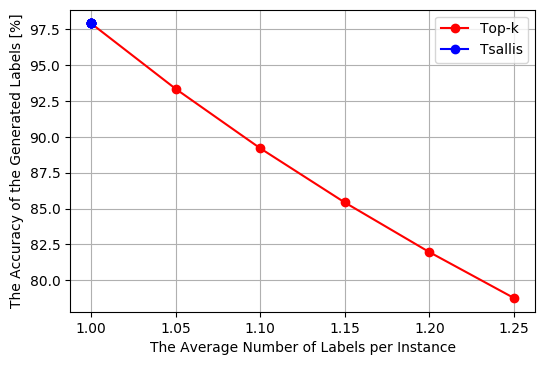

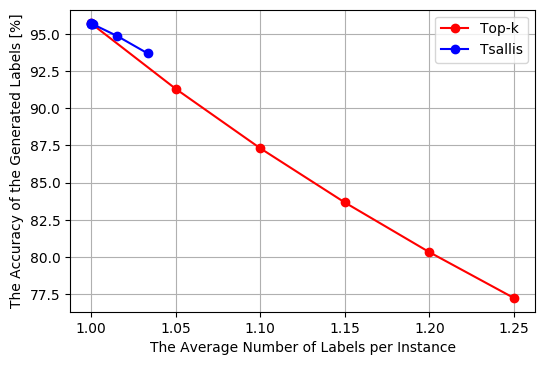

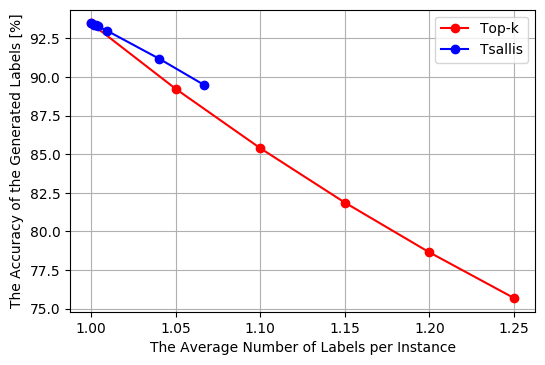

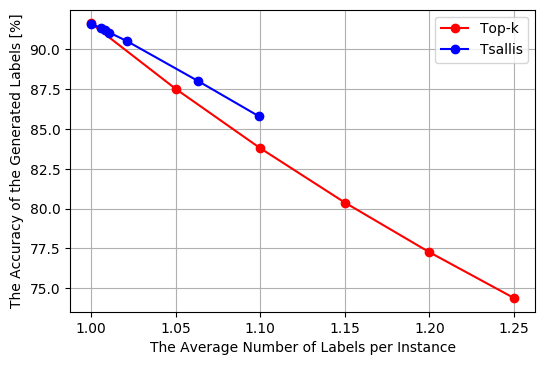

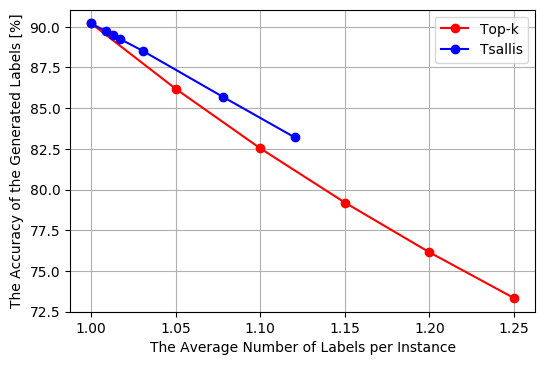

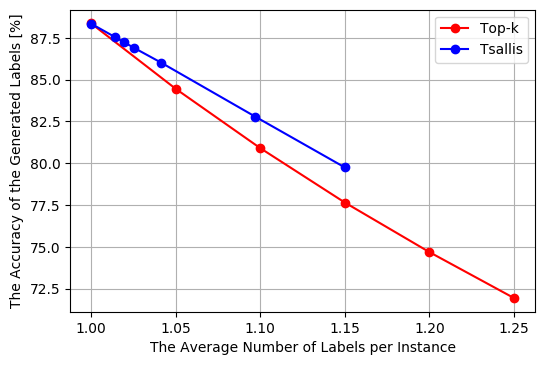

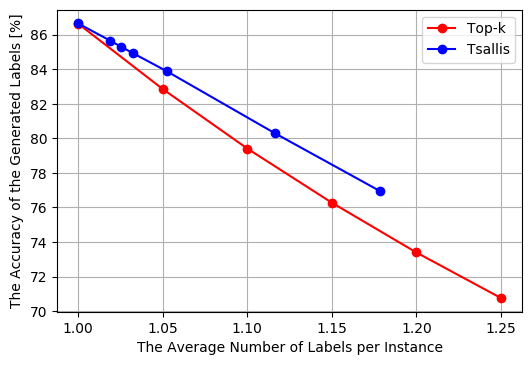

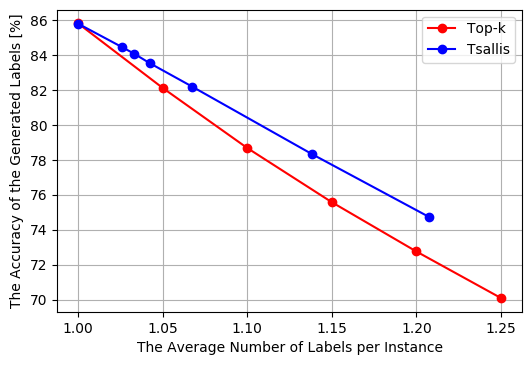

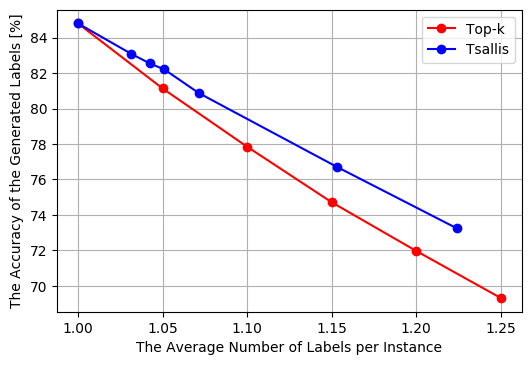

In [20]:
for i in range(9):
    lqual = [results_list[j][i][1] for j in range(6)]
    tsallis_lnumave = [e[i] for e in qlnum]
    tsallis = [e[i] for e in qqual]
    graph_it(lqual, tsallis_lnumave, tsallis, i + 2)